In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

/Users/bpo/opt/anaconda3/envs/mxlearn/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
ERA5meta = pd.read_csv("../annotatedDATA/META/ERA5_META.csv")

In [3]:
CARIACO = pd.read_csv("../DATA/January/Combined_CARIACO_data_v6.csv")

CARIACO.columns.values

array(['Unnamed: 0', 'cdww', 'iews', 'inss', 'mcc', 'mwp', 'si10', 'sp',
       'sst', 't2m', 'tauoc', 'u10', 'ust', 'v10', 'v10n', 'vst', 'wind',
       'time_month', 'cdir', 'e', 'ewss', 'i10fg', 'lsp', 'magss', 'mer',
       'metss', 'mmtss', 'mntss', 'mtpr', 'nsss', 'sshf', 'tp', 'NO3_UDO',
       'PO4_UDO', 'SiO4_UDO', 'NH4_USF', 'NO2_USF', 'NO3_NO2_USF',
       'PO4_USF', 'SiO4_USF', 'pH_corrected', 'Salinity_bottles',
       'Temperature', 'Sigma_t', 'PrimaryProductivity', 'Chlorophyll',
       'Phaeopigments', 'NO3_USF', 'NO3_UDO_35m', 'PO4_UDO_35m',
       'SiO4_UDO_35m', 'NH4_USF_35m', 'NO2_USF_35m', 'NO3_NO2_USF_35m',
       'PO4_USF_35m', 'SiO4_USF_35m', 'pH_corrected_35m',
       'Salinity_bottles_35m', 'Temperature_35m', 'Sigma_t_35m',
       'PrimaryProductivity_35m', 'Chlorophyll_35m', 'Phaeopigments_35m',
       'NO3_USF_35m', 'NO3_UDO_35to100m', 'PO4_UDO_35to100m',
       'SiO4_UDO_35to100m', 'NH4_USF_35to100m', 'NO2_USF_35to100m',
       'NO3_NO2_USF_35to100m', 'PO4_

In [4]:
CARIACO['date'] = pd.to_datetime(CARIACO['time_month'])
CARIACO = CARIACO.set_index('date')

In [5]:
ERA5 = CARIACO[['cdww', 'iews', 'inss', 'mcc', 'mwp', 'si10', 'sp',
       'sst', 't2m', 'tauoc', 'u10', 'ust', 'v10', 'v10n', 'vst', 'wind',
    'cdir', 'e', 'ewss', 'i10fg', 'lsp', 'magss', 'mer',
       'metss', 'mmtss', 'mntss', 'mtpr', 'nsss', 'sshf', 'tp',
        ]].dropna()

In [6]:
ERA5['year'] = ERA5.index.year

In [7]:
ERA5meta[['GRIB_name', 'GRIB_cfVarName', 'GRIB_units']]

,GRIB_name,GRIB_cfVarName,GRIB_units
0,10 metre U wind component,u10,m s**-1
1,Neutral wind at 10 m v-component,v10n,m s**-1
2,10 metre V wind component,v10,m s**-1
3,10 metre wind speed,si10,m s**-1
4,Instantaneous 10 metre wind gust,i10fg,m s**-1
5,Mean wave period,mwp,s
6,Coefficient of drag with waves,cdww,dimensionless
7,Instantaneous eastward turbulent surface stress,iews,N m**-2
8,Instantaneous northward turbulent surface stress,inss,N m**-2
9,Eastward turbulent surface stress,ewss,N m**-2 s


In [8]:
ERA5clean = ERA5.drop('year', axis=1)._get_numeric_data().dropna()
ERA5clean.head()

,cdww,iews,inss,mcc,mwp,si10,sp,sst,t2m,tauoc,...,lsp,magss,mer,metss,mmtss,mntss,mtpr,nsss,sshf,tp
date,,,,,,,,,,,,,,,,,,,,,
1995-11-01,0.000912,-0.054353,-0.025692,0.097103,5.124629,6.113998,101075.125,300.71152,299.72668,0.978549,...,0.000208,6192.3228,-0.000041,-0.063720,0.071691,-0.028754,1.188099e-05,-2488.6484,-668755.0,0.001027
1995-12-01,0.000934,-0.057572,-0.031501,0.071477,5.149414,6.504798,101168.125,299.28598,298.87793,0.975202,...,0.000056,6760.8560,-0.000030,-0.067293,0.078194,-0.035218,1.320477e-06,-3042.9258,-253528.0,0.000115
1996-01-01,0.000979,-0.068143,-0.037201,0.076384,5.239093,7.016142,101168.810,298.53207,298.06640,0.967328,...,0.000066,7976.0273,-0.000034,-0.079299,0.092283,-0.041197,1.670900e-06,-3556.2266,-272642.0,0.000143
1996-02-01,0.001028,-0.085607,-0.047099,0.079045,4.748802,7.786757,101173.690,298.30145,298.15515,0.958666,...,0.000043,9619.2580,-0.000031,-0.095999,0.111392,-0.050238,6.747709e-07,-4342.0900,-12840.0,0.000059
1996-03-01,0.001057,-0.096076,-0.052923,0.067093,4.762285,8.154397,101191.125,297.70407,297.81580,0.954383,...,0.000026,10874.3240,-0.000028,-0.108240,0.125832,-0.057302,4.256869e-07,-4947.4844,258676.0,0.000038


In [9]:
BRT1b = CARIACO[['mcc', 'mwp', 'sp', 'cdir', 'sst','tp', 'Satellite_chla']].dropna()

X = BRT1b.drop('Satellite_chla', axis=1)
#y = np.log10(BRT1b['Satellite_chla'])

In [10]:
plt.rcParams['figure.figsize'] = [10, 5]

In [11]:
testdat = np.log10(BRT1b.Satellite_chla.to_frame())
testdat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 1997-10-01 to 2020-06-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Satellite_chla  274 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


<AxesSubplot:title={'center':'Satellite Chla'}, xlabel='date'>

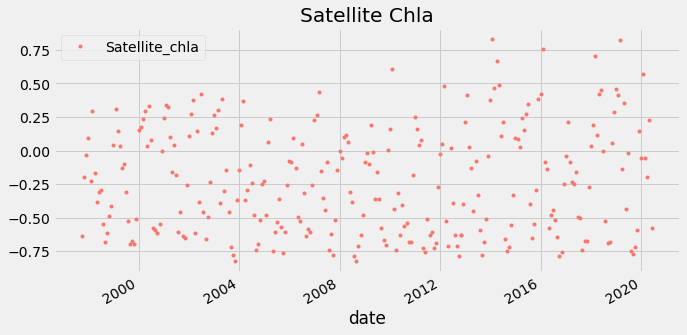

In [12]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
testdat.plot(style='.', color=color_pal[0], title='Satellite Chla')

In [13]:
split_date = '01-Jan-2015'
y_train = testdat.loc[testdat.index <= split_date].copy()
y_test = testdat.loc[testdat.index > split_date].copy()

In [14]:
X_train = X.loc[testdat.index <= split_date].copy()
X_test = X.loc[testdat.index > split_date].copy()

<AxesSubplot:title={'center':'Satellite Chl a'}, xlabel='date'>

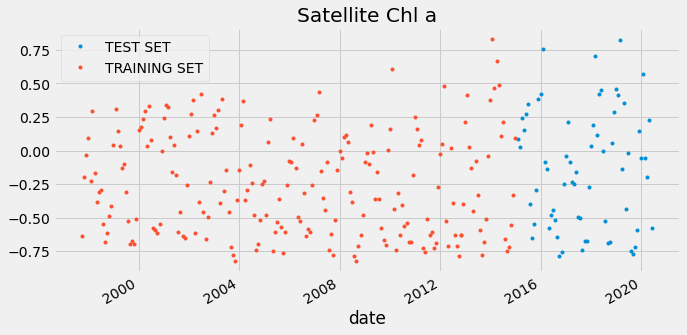

In [15]:
y_test \
    .rename(columns={'Satellite_chla': 'TEST SET'}) \
    .join(y_train.rename(columns={'Satellite_chla': 'TRAINING SET'}), how='outer') \
    .plot(title='Satellite Chl a', style='.')

# 1. test previous random forest regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, oob_score=True,)
rf.fit(X_train, y_train.values[:,0])

RandomForestRegressor(n_estimators=1000, oob_score=True)

In [17]:
from sklearn.metrics import explained_variance_score
#rf.fit(X_train, y_train)
predicted_testBiom = rf.predict(X_test)

print('oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - rf.oob_score_, rf.score(X_test, y_test),
             explained_variance_score(y_test, predicted_testBiom) * 100))

oob-error=0.23, r^2=0.78, % Var explained=78.11


### for reference, values for random split:

oob-error=0.21, r^2=0.73, % Var explained=73.06

In [18]:
rf.feature_importances_

array([0.02686159, 0.02676019, 0.04244644, 0.03050847, 0.85209451,
       0.02132878])

Text(0.5, 0, 'Random Forest Feature Importance')

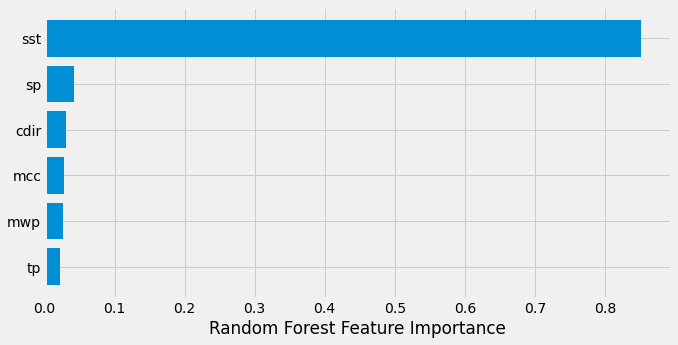

In [19]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [20]:
SatChl_test1 = y_test.copy()
SatChl_test1['Prediction'] = rf.predict(X_test)
SatChl_all1 = pd.concat([SatChl_test1, y_train], sort=False)

<AxesSubplot:xlabel='date'>

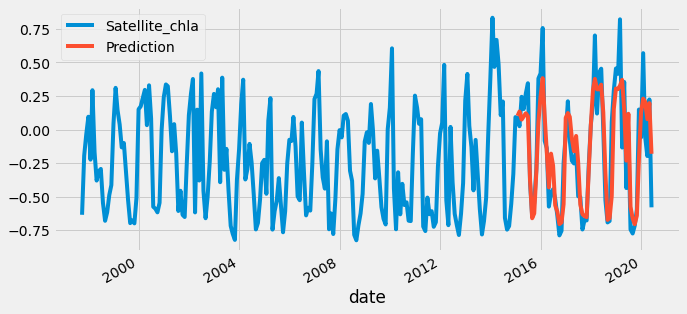

In [21]:
SatChl_all1[['Satellite_chla','Prediction']].plot()

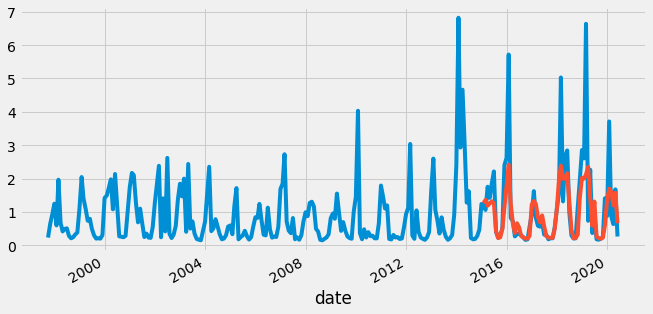

In [29]:
BRT1b.Satellite_chla.plot()
plt.plot(10**SatChl_all1.Prediction)

# 2. test XGBoost

In [30]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/Users/bpo/opt/anaconda3/envs/mxlearn/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

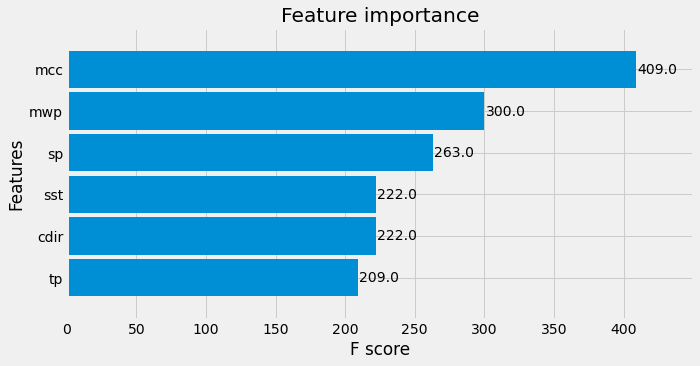

In [31]:
plot_importance(reg, height=0.9)

In [32]:
SatChl_test = y_test.copy()
SatChl_test['Prediction'] = reg.predict(X_test)
SatChl_all = pd.concat([SatChl_test, y_train], sort=False)

<AxesSubplot:xlabel='date'>

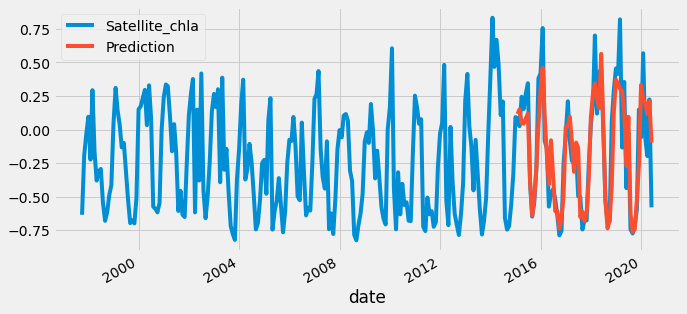

In [34]:
SatChl_all[['Satellite_chla','Prediction']].plot()

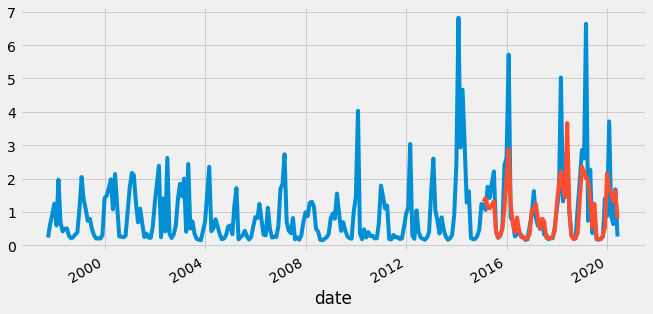

In [44]:
BRT1b.Satellite_chla.plot()
plt.plot(10**SatChl_all.Prediction)

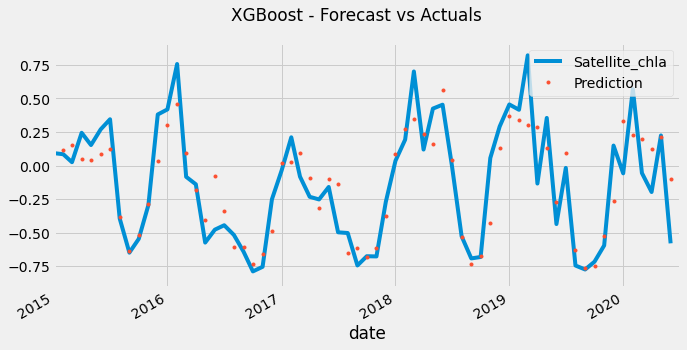

In [35]:
f, ax = plt.subplots(1)

SatChl_all[['Satellite_chla','Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='07-01-2020')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('XGBoost - Forecast vs Actuals')

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
mean_squared_error(y_true=SatChl_test['Satellite_chla'],
                   y_pred=SatChl_test['Prediction'])

0.04417023788565808

In [40]:
mean_absolute_percentage_error(y_true=10**SatChl_test['Satellite_chla'],
                   y_pred=10**SatChl_test['Prediction'])

38.68338401623063

In [51]:
np.std(10**SatChl_test['Prediction'])

0.7532164

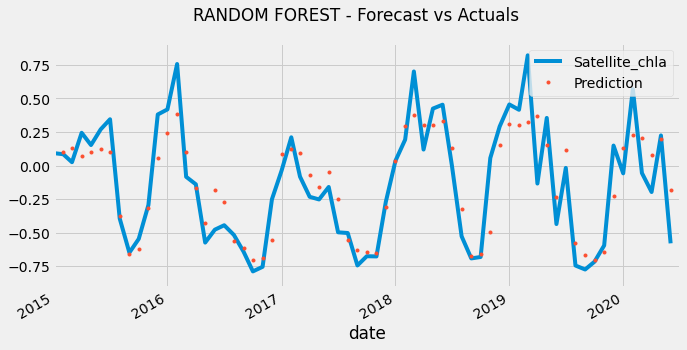

In [38]:
f, ax = plt.subplots(1)

SatChl_all1[['Satellite_chla','Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='07-01-2020')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('RANDOM FOREST - Forecast vs Actuals')

In [59]:
mean_squared_error(y_true=SatChl_test1['Satellite_chla'],
                   y_pred=SatChl_test1['Prediction'])

0.041666136534151035

In [41]:
mean_absolute_percentage_error(y_true=10**SatChl_test1['Satellite_chla'],
                   y_pred=10**SatChl_test1['Prediction'])

37.74324875353938

In [50]:
np.std(10**SatChl_test1['Prediction'])

0.6773548233983044

# now a model predicting the isotherm

In [79]:
iso21 = CARIACO[['mcc', 'mwp', 'sst', 'cdir', 'wind','tp', 'Isotherm_21']].dropna()

X2 = iso21.drop('Isotherm_21', axis=1)
y2 = iso21['Isotherm_21'].to_frame()

<AxesSubplot:title={'center':'21 degree isotherm'}, xlabel='date'>

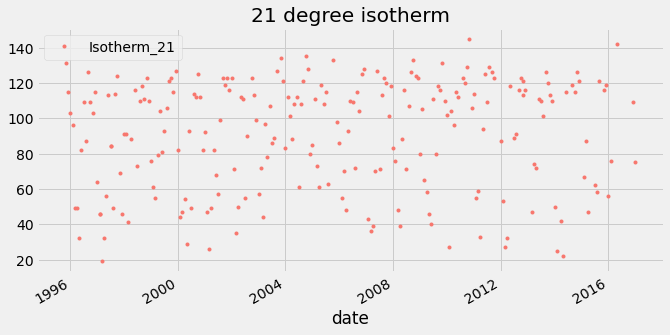

In [80]:
y2.plot(style='.', color=color_pal[0], title='21 degree isotherm')

In [81]:
split_date = '01-Jan-2011'
y_trainn = y2.loc[y2.index <= split_date].copy()
y_testt = y2.loc[y2.index > split_date].copy()

In [82]:
X_trainn = X2.loc[X2.index <= split_date].copy()
X_testt = X2.loc[X2.index > split_date].copy()

<AxesSubplot:title={'center':'Isotherm_21'}, xlabel='date'>

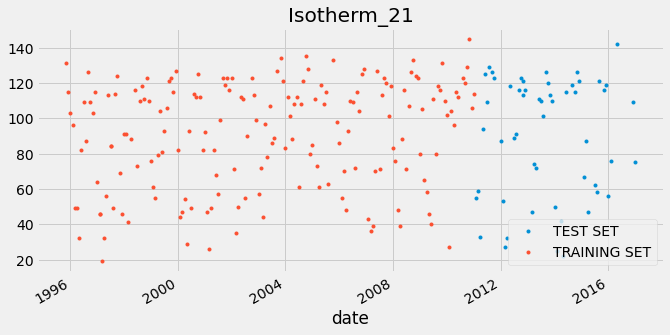

In [83]:
y_testt \
    .rename(columns={'Isotherm_21': 'TEST SET'}) \
    .join(y_trainn.rename(columns={'Isotherm_21': 'TRAINING SET'}), how='outer') \
    .plot(title='Isotherm_21', style='.')

In [84]:
from sklearn.ensemble import RandomForestRegressor
rfi = RandomForestRegressor(n_estimators=1000, oob_score=True,)
rfi.fit(X_trainn, y_trainn.values[:,0])

RandomForestRegressor(n_estimators=1000, oob_score=True)

In [85]:
from sklearn.metrics import explained_variance_score
#rf.fit(X_train, y_train)
predicted_isotherm = rfi.predict(X_testt)

print('oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - rfi.oob_score_, rfi.score(X_testt, y_testt),
             explained_variance_score(y_testt, predicted_isotherm) * 100))

oob-error=0.37, r^2=0.64, % Var explained=63.88


In [86]:
rfi.feature_importances_

array([0.05378035, 0.08392519, 0.67643171, 0.09947894, 0.04659934,
       0.03978446])

Text(0.5, 0, 'Random Forest Feature Importance')

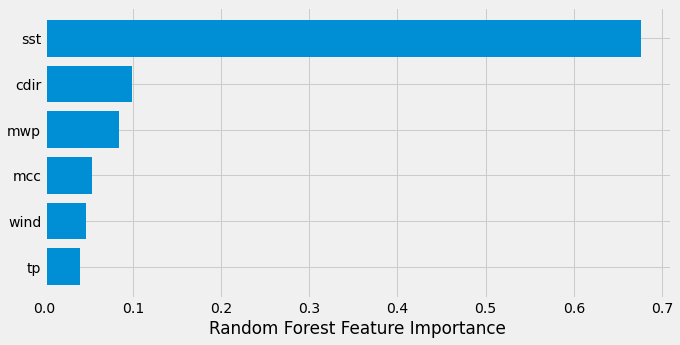

In [87]:
sorted_idx = rfi.feature_importances_.argsort()
plt.barh(X2.columns[sorted_idx], rfi.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [88]:
SatChl_testx = y_testt.copy()
SatChl_testx['Prediction'] = rfi.predict(X_testt)
SatChl_allx = pd.concat([SatChl_testx, y_trainn], sort=False)

<AxesSubplot:xlabel='date'>

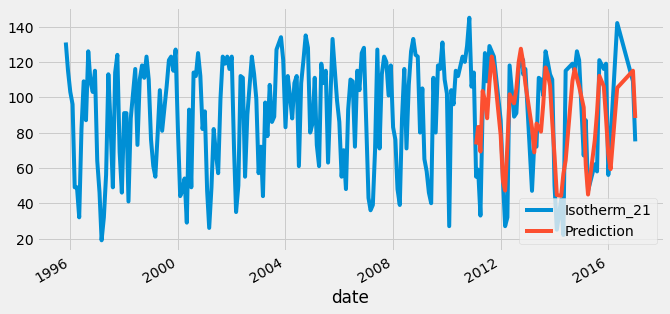

In [93]:
SatChl_allx[['Isotherm_21','Prediction']].plot()

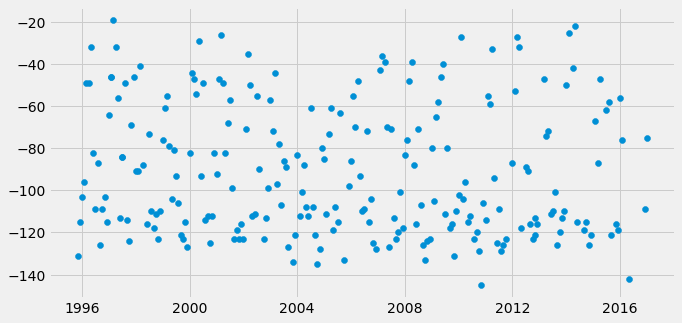

In [102]:
plt.scatter(CARIACO.index,-CARIACO.Isotherm_21)

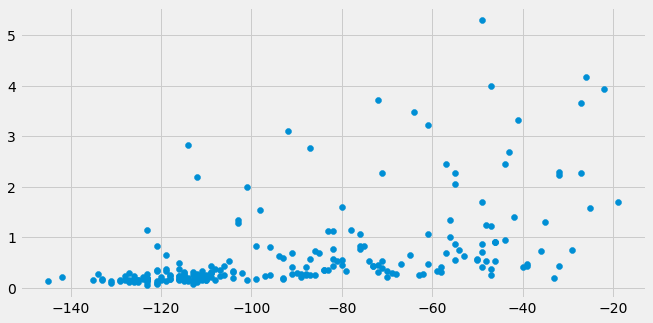

In [97]:
plt.scatter(-CARIACO.Isotherm_21, CARIACO.Chlorophyll_35m)

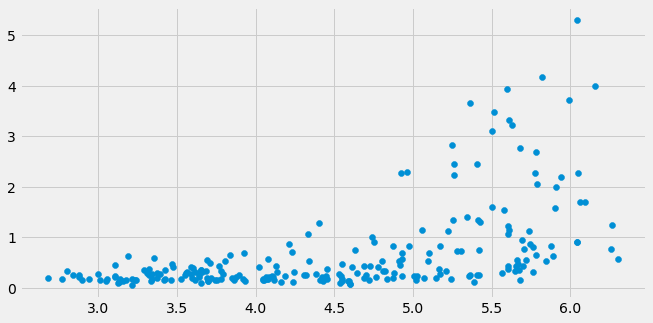

In [100]:
plt.scatter(CARIACO.wind, CARIACO.Chlorophyll_35m)

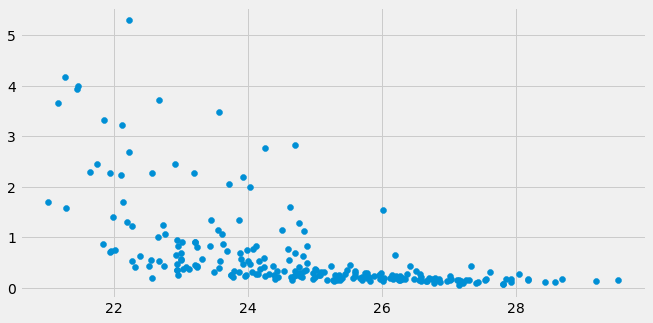

In [99]:
plt.scatter(CARIACO.Temperature_35m, CARIACO.Chlorophyll_35m)